In [1]:
%matplotlib inline
import os
import pandas as pd
from llama_4bit_wrapper import import_llama, lora_model_zeros_and_scales_to_half
from peft import LoraConfig, get_peft_model
from llama_memorizing_transformers.memory_collection import CosineKnnMemoryCollection
from llama_memorizing_transformers.context_choice import ContextChoiceLinear
from llama_memorizing_transformers.model_wrapper import replace_llama_layer_with_memory
from llama_memorizing_transformers.document_trainer import MemorizingLlamaDocumentTrainer
from torch.optim import Adam
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from itertools import chain
from torch.nn.functional import softmax
import gc

/home/alex4321/anaconda3/envs/longdocchat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42

# Dataset
DATASET_PATH = "long-vicuna-set-lessgpt4all-vicuna13b-processed"

# Training procedure
CONTEXT_LENGTH = 512
CONTEXT_STEP = 256
PRETRAIN_LENGTH = 1024
# Model
COSINE_KNN_MAX_TEMPORARY_BUFFER_SIZE = 1024
REPLACE_LAYER = 21
BASE_MODEL = "../vicuna-13b-GPTQ-4bit-128g"
BASE_MODEL_WEIGHTS = "../vicuna-13b-GPTQ-4bit-128g/vicuna-13b-4bit-128g.safetensors"

USE_FP16 = True
LR_PRETRAIN = 3e-4

In [3]:
_, _, load_llama_model_4bit_low_ram, _, model_to_half, _, _, _, AMPWrapper = import_llama(
    use_flash_attention=False,
    use_xformers=False,
    autograd_4bit_cuda=False,
    autograd_4bit_triton=True,
)

Using Triton implementation.


## Data reading

In [4]:
df_texts = pd.read_pickle(os.path.join(DATASET_PATH, "texts.pkl"))
df_texts.head()

,processed_text,input_ids,length
0,<msg_prompter> Can you write a short introduct...,"[529, 7645, 29918, 14032, 29886, 357, 29958, 1...",50
1,"<msg_assistant> ""Monopsony"" refers to a market...","[529, 7645, 29918, 465, 22137, 29958, 376, 718...",351
2,<msg_prompter> Now explain it to a dog,"[529, 7645, 29918, 14032, 29886, 357, 29958, 2...",13
3,<msg_assistant> Monopsony is a market structur...,"[529, 7645, 29918, 465, 22137, 29958, 2598, 45...",238
4,<msg_prompter> How can one fight back when a m...,"[529, 7645, 29918, 14032, 29886, 357, 29958, 1...",22


In [5]:
df_indices_train = pd.read_pickle(os.path.join(DATASET_PATH, "indices-train.pkl"))
df_indices_train.head()

,indices,source,session_length
0,"[0, 1, 2]",openassistant,414
1,"[0, 3, 4]",openassistant,310
2,"[0, 5, 6, 7]",openassistant,426
3,"[0, 5, 6, 8]",openassistant,595
4,"[0, 5, 6, 9]",openassistant,334


In [6]:
df_indices_validation = pd.read_pickle(os.path.join(DATASET_PATH, "indices-validation.pkl"))
df_indices_validation.head()

,indices,source,session_length
0,"[82483, 82484]",openassistant,302
1,"[82483, 82485]",openassistant,218
2,"[82483, 82486]",openassistant,79
3,"[82487, 82488]",openassistant,561
4,"[82487, 82489, 82490, 82491]",openassistant,546


In [7]:
mask = (df_indices_validation["session_length"] > CONTEXT_LENGTH) & (df_indices_validation["session_length"] <= PRETRAIN_LENGTH)
df_indices_validation = df_indices_validation.loc[mask]
df_indices_validation.head()

,indices,source,session_length
3,"[82487, 82488]",openassistant,561
4,"[82487, 82489, 82490, 82491]",openassistant,546
5,"[82487, 82489, 82490, 82492]",openassistant,570
6,"[82487, 82489, 82490, 82493]",openassistant,740
7,"[82487, 82494, 82495, 82496]",openassistant,644


## Model preparation

In [8]:
model, tokenizer = load_llama_model_4bit_low_ram(
    config_path=BASE_MODEL,
    model_path=BASE_MODEL_WEIGHTS,
    groupsize=128,
    is_v1_model=False,
)
tokenizer.pad_token_id = 0

model_to_half(model)
wrapper = AMPWrapper(model)
wrapper.apply_forward()
wrapper

Loading Model ...


The safetensors archive passed at ../vicuna-13b-GPTQ-4bit-128g/vicuna-13b-4bit-128g.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


Loaded the model in 3.58 seconds.
Converted as Half.


## Common functions

In [9]:
def get_perplexity(input_ids, inference_function):
    with torch.no_grad():
        prediction_proba = inference_function(input_ids).detach().cpu().numpy()
        labels = input_ids[0, 1:]
        predicted_tokens = prediction_proba[0, :-1]
        label_token_probas = np.array([predicted_tokens[i, token] for i, token in enumerate(labels)])
        label_token_probas_normed = label_token_probas ** (1/len(label_token_probas))
        result = 1.0
        for item in label_token_probas_normed:
            if item != 0: # For some technical tokens (part of prompts, not data) original vicuna returned exactly zero probability
                result *= item
    return 1.0 / result

## Basic inference mode

In [10]:
def make_basic_inference_function(model):
    def _func(input_ids):
        model.eval()
        prediction = model(input_ids=input_ids)
        prediction_proba = softmax(prediction.logits, dim=-1)
        return prediction_proba

    return _func

In [11]:
with torch.no_grad():
    perplexities_normal = []
    for _, row in tqdm(df_indices_validation.iterrows(), total=df_indices_validation.shape[0]):
        df_row_texts = df_texts.loc[row["indices"]]
        text = "\n".join(df_row_texts["processed_text"])
        input_ids = torch.LongTensor(tokenizer(text)["input_ids"]).view((1, -1)).to(model.device)
        perplexity = get_perplexity(input_ids, make_basic_inference_function(model))
        perplexities_normal.append(perplexity)

100%|██████████| 1130/1130 [37:34<00:00,  2.00s/it]


In [12]:
input_ids.shape

torch.Size([1, 856])

In [13]:
np.array(perplexities_normal).mean()

5.953638991949186

<Axes: >

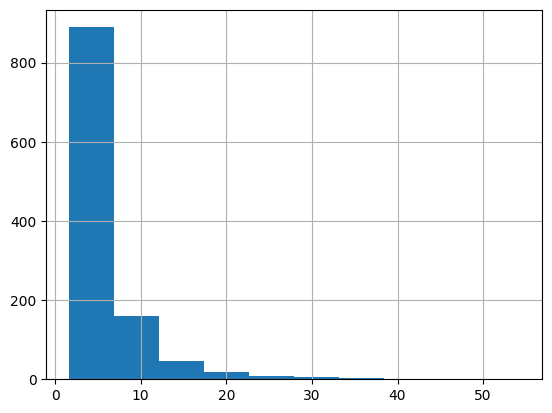

In [14]:
pd.Series(perplexities_normal).hist()

## Short context window + shifting

In [15]:
def make_sliding_inference_function(model):
    def _func(input_ids):
        model.eval()
        start = 0
        probas = {}
        while True:
            end = start + CONTEXT_LENGTH
            chunk_input_ids = input_ids[:, start:end]
            end_real = start + chunk_input_ids.shape[1]
            chunk_prediction = model(input_ids=chunk_input_ids)
            chunk_prediction_proba = softmax(chunk_prediction.logits, dim=-1).detach().cpu().numpy()
            added = 0
            for i in range(start, end_real):
                if i in probas:
                    continue
                probas[i] = chunk_prediction_proba[0, i - start]
                added += 1
            start += CONTEXT_STEP
            if added == 0:
                break
        prediction_proba = []
        for i in range(len(probas)):
            prediction_proba.append(probas[i])
        prediction_proba = np.array([prediction_proba])
        return torch.FloatTensor(prediction_proba)
    
    return _func

In [16]:
with torch.no_grad():
    perplexities_shifted = []
    for _, row in tqdm(df_indices_validation.iterrows(), total=df_indices_validation.shape[0]):
        df_row_texts = df_texts.loc[row["indices"]]
        text = "\n".join(df_row_texts["processed_text"])
        input_ids = torch.LongTensor(tokenizer(text)["input_ids"]).view((1, -1)).to(model.device)
        perplexity = get_perplexity(input_ids, make_sliding_inference_function(model))
        perplexities_shifted.append(perplexity)

100%|██████████| 1130/1130 [1:02:12<00:00,  3.30s/it]


In [17]:
np.array(perplexities_shifted).mean()

6.285509805678134

<Axes: >

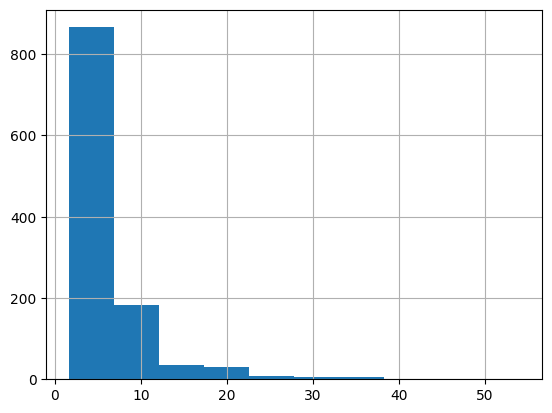

In [18]:
pd.Series(perplexities_shifted).hist()

## Sliding window + memory

In [19]:
model.cpu()
gc.collect()
torch.cuda.empty_cache()

In [20]:
model, tokenizer = load_llama_model_4bit_low_ram(
    config_path=BASE_MODEL,
    model_path=BASE_MODEL_WEIGHTS,
    groupsize=128,
    is_v1_model=False,
)
tokenizer.pad_token_id = 0

context_choice = ContextChoiceLinear(model.config.num_attention_heads,
                                     model.config.hidden_size)
memory = CosineKnnMemoryCollection(COSINE_KNN_MAX_TEMPORARY_BUFFER_SIZE,
                                   remember_until_position=0)
model.model = replace_llama_layer_with_memory(
    model.model,
    REPLACE_LAYER,
    context_choice,
    memory,
)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.0,
    bias="none",
    task_type="CAUSAL_LM",
)
lora_model = get_peft_model(model, lora_config)
lora_model = lora_model_zeros_and_scales_to_half(lora_model)
lora_model.config.use_cache = False
wrapper = AMPWrapper(lora_model)
wrapper.apply_forward()

Loading Model ...


The safetensors archive passed at ../vicuna-13b-GPTQ-4bit-128g/vicuna-13b-4bit-128g.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


Loaded the model in 2.89 seconds.


In [ ]:
lora_model.cpu()
gc.collect()
torch.cuda.empty_cache()

In [24]:
lora_model.load_state_dict(torch.load(
    "long-vicuna--pretrain--state-dict.pth",
    map_location=torch.device("cpu")
))
lora_model.cuda()

PeftModelForCausalLM(
  (base_model): GPTQLoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32001, 5120, padding_idx=0)
        (layers): ModuleList(
          (0-20): 21 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bitLt(
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=5120, bias=False)
                )
              )
              (k_proj): Autograd4bitQuantLinear()
              (v_proj): Linear4bitLt(
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, 

In [25]:
with torch.no_grad():
    perplexities_memory = []
    for _, row in tqdm(df_indices_validation.iterrows(), total=df_indices_validation.shape[0]):
        df_row_texts = df_texts.loc[row["indices"]]
        input_ids = torch.cat([
             torch.LongTensor(data.astype(np.int32))
             for data in df_row_texts["input_ids"]
        ], dim=0)
        memory.reset()
        memory.remember_until_position = PRETRAIN_LENGTH
        input_ids = input_ids.view((1, -1)).to(lora_model.device)
        perplexity = get_perplexity(input_ids, make_sliding_inference_function(lora_model))
        perplexities_memory.append(perplexity)

100%|██████████| 1130/1130 [1:03:43<00:00,  3.38s/it]


In [26]:
np.array(perplexities_memory).mean()

4.110597224135854

<Axes: >

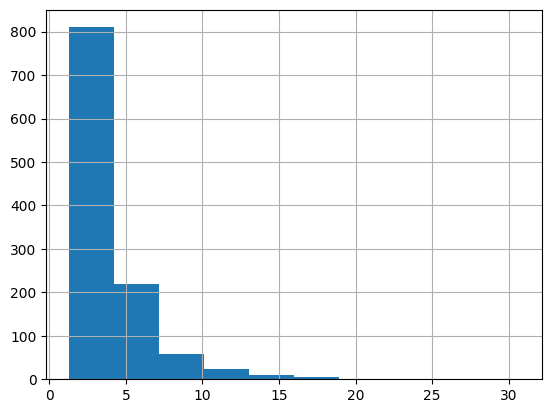

In [27]:
pd.Series(perplexities_memory).hist()